# Machine Learning (ML) Exploratory Data Analysis

The intent of this notebook is three-fold:
* First an Exploratory Data Analysis (EDA) is conducted to visualise the distribution of the tabular dataset built on a S2 image with the `1.1_label_generator.ipynb` Notebook
* Next, review the correlation of some of the S2 spectral bands in the task of water classification. 
* Finally, feature engineering and outlier detection for improving the dataset 

## 1. Import Libraries

In [1]:
import os
import sys
import csv
import glob
import joblib
import numpy as np
import pandas as pd
from pathlib import Path

# Machine Learning imports
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier as cumlRF
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV, KFold
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA

# Visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Geospatial related imports
from osgeo import gdalconst
from osgeo import gdal

from pprint import pprint

# Ignore a few warnings for cleaner output
warnings.filterwarnings('ignore')
%matplotlib inline

## 2. Define General Variables

In this section we define general variables to work with through this notebook. A description of each variable is listed below as a comment next to the variable definition.

In [2]:
# column name for label, in our case this will be a categorical value
LABEL_NAME = 'water'

# data type of the label, you would change this to something else if your
# problem was for example a regression problem of type np.float32
DATA_TYPE = np.int16

# columns not needed for training
colsToDrop = ['Index', 'long', 'lat', 'LUC']

Here we create an output directory to store any artifacts out of our EDA visualizations.

In [3]:
os.makedirs('output', exist_ok=True)

## 3. Data Loading

In this section we will go ahead and load our data to analyze. We have extracted a tabular dataset from MODIS GeoTIFF files for the purpose of performing EDA. Here we will:
  - Read in data to a Dataframe
  - Drop unnecessary columns
  - Split into Xs and Ys

In [4]:
%%time
df_pandas = pd.read_csv('df_extractedpixels.csv', usecols=lambda column: column not in colsToDrop)
df_pandas

CPU times: user 1.46 ms, sys: 7.01 ms, total: 8.47 ms
Wall time: 11.2 ms


,coastal,blue,green,red,rededge70,rededge74,rededge78,nir,nir08,nir09,swir16,swir22,ndvi,ndwi1,ndwi2,water
0,318,363,542,754,947,1013,1094,1115,1209,1182,2141,2069,1931,-3151,-2996,0.0
1,365,448,552,738,874,942,1027,1062,1213,1142,2328,2275,1800,-3734,-3635,0.0
2,833,432,645,872,1147,1474,1612,1534,1706,2020,2059,1696,2751,-1461,-501,0.0
3,308,312,507,533,821,1679,1896,1952,2051,2317,1694,977,5710,707,3328,0.0
4,261,394,650,1044,1251,1417,1406,1454,1547,1343,2629,2482,1641,-2877,-2611,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,156,1,78,29,173,392,462,61,525,1654,622,431,3555,-8213,-7520,0.0
396,241,260,574,710,1338,2327,2761,2927,3125,2833,2009,1191,6095,1859,4215,0.0
397,416,462,640,891,1147,1183,1290,1265,1320,1416,2100,2119,1734,-2481,-2523,0.0
398,91,246,480,443,768,2077,2467,2766,2668,2291,1426,788,7239,3196,5565,0.0


## 4. Data Cleaning

In this section we will start to inspect and understand the nature of our dataset.

The simplest first step when we have a DataFrame dataset is to inspect the data types, columns, attributes, and shape of our dataset.

In [5]:
df_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   coastal    400 non-null    int64  
 1   blue       400 non-null    int64  
 2   green      400 non-null    int64  
 3   red        400 non-null    int64  
 4   rededge70  400 non-null    int64  
 5   rededge74  400 non-null    int64  
 6   rededge78  400 non-null    int64  
 7   nir        400 non-null    int64  
 8   nir08      400 non-null    int64  
 9   nir09      400 non-null    int64  
 10  swir16     400 non-null    int64  
 11  swir22     400 non-null    int64  
 12  ndvi       400 non-null    int64  
 13  ndwi1      400 non-null    int64  
 14  ndwi2      400 non-null    int64  
 15  water      400 non-null    float64
dtypes: float64(1), int64(15)
memory usage: 50.1 KB


Pandas provides an excellent function to inspect the contents of our dataframes in a more concise way. Note the number of observations per feature, and the minimum and maximum values per MODIS band.

In [6]:
df_pandas.describe().T

,count,mean,std,min,25%,50%,75%,max
coastal,400.0,356.2750,356.209246,1.0,182.75,285.5,404.75,3580.0
blue,400.0,435.5100,431.492043,1.0,232.00,352.0,524.25,3776.0
green,400.0,657.9050,465.474378,40.0,430.00,567.0,752.50,4288.0
red,400.0,759.8225,508.406924,26.0,423.75,671.5,992.25,4484.0
rededge70,400.0,1076.7375,528.559819,1.0,785.75,993.0,1278.75,6044.0
rededge74,400.0,1666.0275,627.470202,1.0,1359.25,1666.0,1975.50,6087.0
rededge78,400.0,1870.0375,683.736576,1.0,1513.25,1884.0,2241.75,5512.0
nir,400.0,1942.1825,720.763292,1.0,1555.00,1957.5,2329.50,4760.0
nir08,400.0,2037.2225,708.915295,1.0,1685.75,2047.0,2446.00,5453.0
nir09,400.0,2060.0250,671.282358,7.0,1718.00,2074.5,2427.25,4823.0


Check if our dataset contains any no-data values

In [7]:
df_pandas[df_pandas.isnull().any(axis=1)]

,coastal,blue,green,red,rededge70,rededge74,rededge78,nir,nir08,nir09,swir16,swir22,ndvi,ndwi1,ndwi2,water


Generally speaking, we can remove rows with no-data values. If we know no-data values belong to a specific group, we might be able to convert it to the appropiate value. 

Once we have dealt with our no-data values, we can go ahead and visualize some of the data to understand its structure and find any patterns.

In [8]:
# Get a sample so we can speed up expensive visualizations
sampledDf = df_pandas.sample(frac=0.5)
sampledDf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 169 to 72
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   coastal    200 non-null    int64  
 1   blue       200 non-null    int64  
 2   green      200 non-null    int64  
 3   red        200 non-null    int64  
 4   rededge70  200 non-null    int64  
 5   rededge74  200 non-null    int64  
 6   rededge78  200 non-null    int64  
 7   nir        200 non-null    int64  
 8   nir08      200 non-null    int64  
 9   nir09      200 non-null    int64  
 10  swir16     200 non-null    int64  
 11  swir22     200 non-null    int64  
 12  ndvi       200 non-null    int64  
 13  ndwi1      200 non-null    int64  
 14  ndwi2      200 non-null    int64  
 15  water      200 non-null    float64
dtypes: float64(1), int64(15)
memory usage: 26.6 KB


In [9]:
df_pandas.sample(n=5)

,coastal,blue,green,red,rededge70,rededge74,rededge78,nir,nir08,nir09,swir16,swir22,ndvi,ndwi1,ndwi2,water
32,324,216,486,362,803,2127,2289,2588,2631,2352,1309,784,7545,3282,5349,0.0
365,88,275,494,588,787,1534,1689,2042,1911,2150,1337,1004,5528,2086,3407,0.0
257,357,308,541,582,825,1414,1567,1728,1679,1884,1933,1602,4961,-559,378,0.0
273,284,348,561,678,904,1415,1588,1739,1685,1765,1808,1352,4389,-194,1252,0.0
249,2113,3776,4288,3304,3160,3552,3380,4315,3494,3318,843,571,1326,6731,7662,0.0


## 5. Exploratory Data Analysis

### 5.1 Correlation plots with water points as orange

This step might take up to 15 minutes depending on hardware. Here we perform a correlation of bands and water/no-water pixels using the seaborn library. This first correlation step can help us find interesting features in our data by looking directly into relationships between our feature columns and our labels. Here we plot multiple pairwise bivariate distributions of the dataset where the diagonal plots are the univariate plots, and this displays the relationship for the (n, 2) combination of variables in a DataFrame as a matrix of plots.

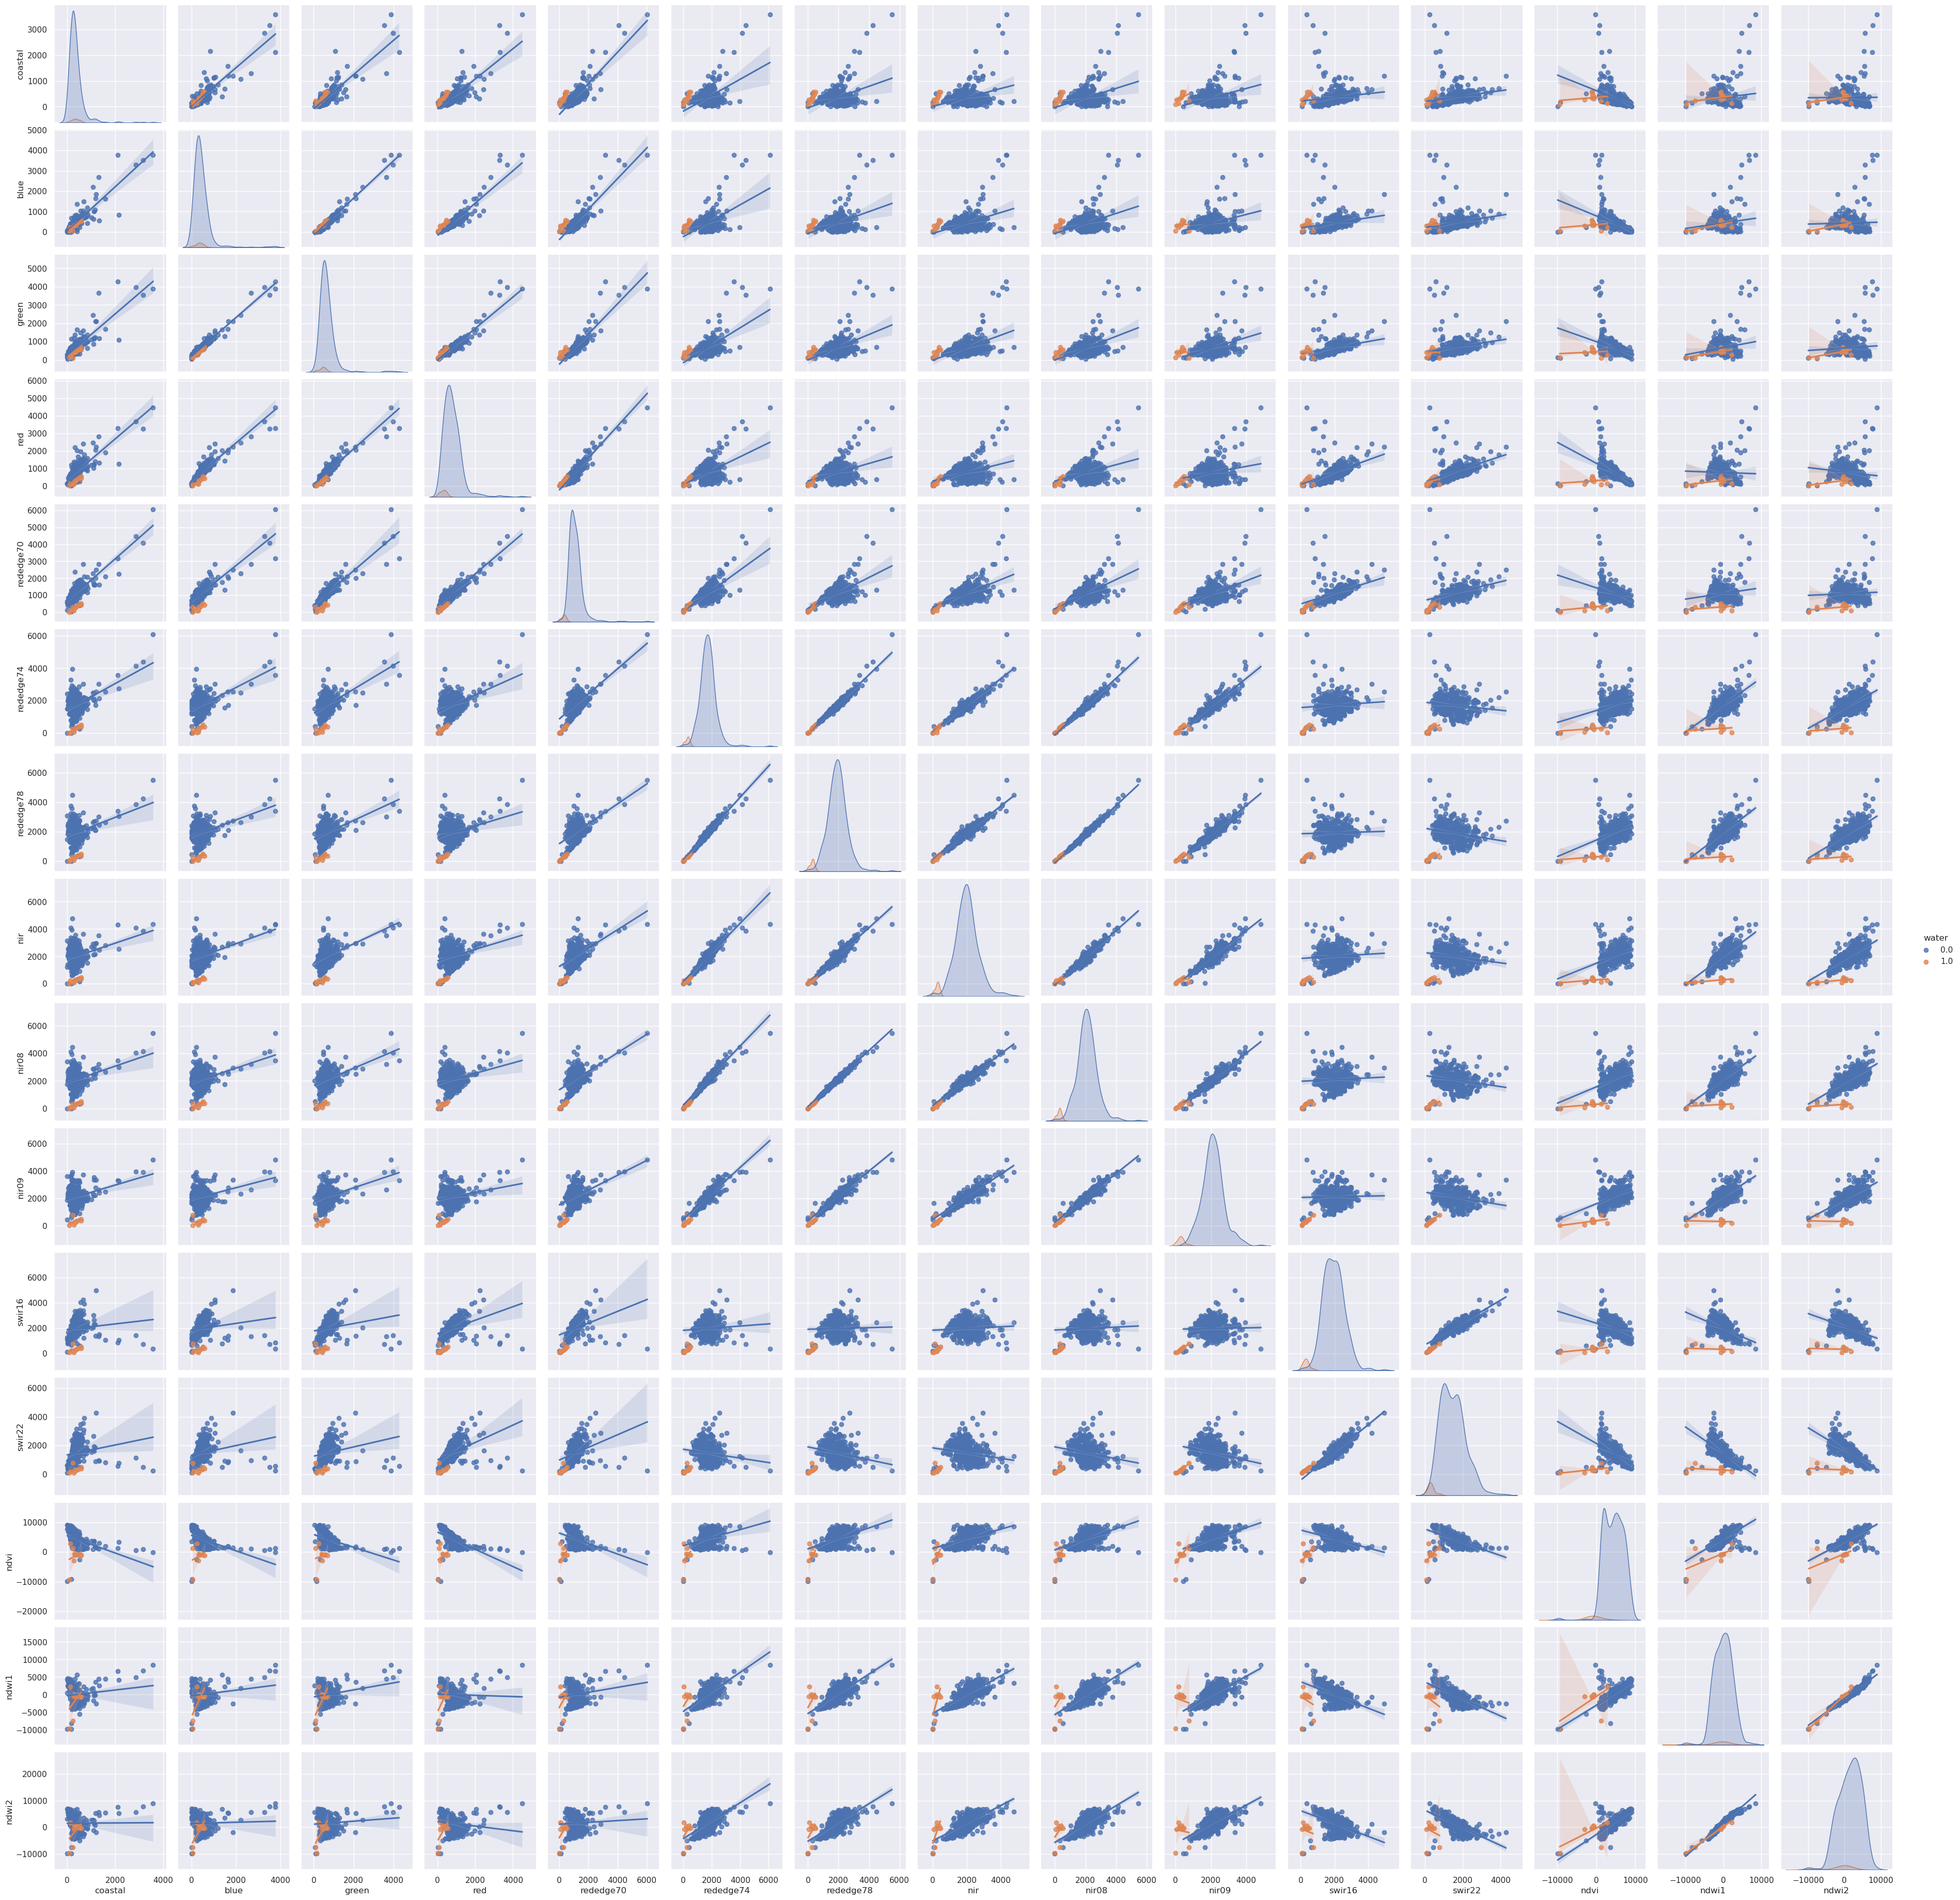

In [10]:
sns.set()
sns.pairplot(df_pandas, hue=LABEL_NAME, kind='reg')
plt.savefig('output/img_test.png')

### 5.2 Distribution for each channel

Another good practice is to understand the distribution of values for each column feature. This will show you where most of your data lives for each feature in the dataset, including the distribution of training labels.

array([[<Axes: title={'center': 'coastal'}>,
        <Axes: title={'center': 'blue'}>,
        <Axes: title={'center': 'green'}>,
        <Axes: title={'center': 'red'}>],
       [<Axes: title={'center': 'rededge70'}>,
        <Axes: title={'center': 'rededge74'}>,
        <Axes: title={'center': 'rededge78'}>,
        <Axes: title={'center': 'nir'}>],
       [<Axes: title={'center': 'nir08'}>,
        <Axes: title={'center': 'nir09'}>,
        <Axes: title={'center': 'swir16'}>,
        <Axes: title={'center': 'swir22'}>],
       [<Axes: title={'center': 'ndvi'}>,
        <Axes: title={'center': 'ndwi1'}>,
        <Axes: title={'center': 'ndwi2'}>,
        <Axes: title={'center': 'water'}>]], dtype=object)

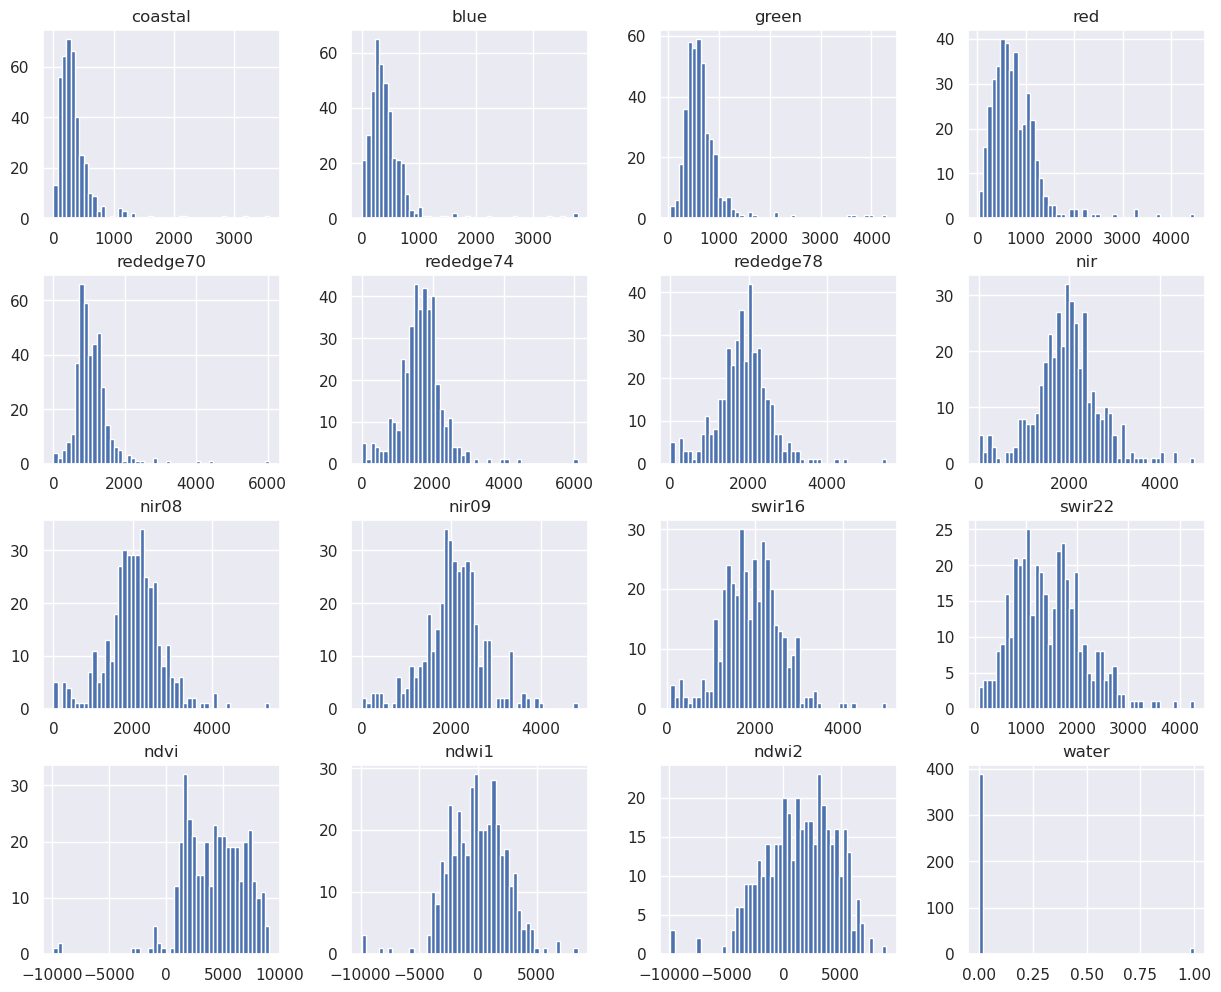

In [11]:
df_pandas.hist(figsize=(15, 12), bins=50)

### 5.3 Correlation calculations

Here we can do a more statistical approach to correlation using pandas corr() function.

In [12]:
# correlation with dataset - target value
corr = df_pandas.corr()[LABEL_NAME]
corr.to_csv('output/correlation.csv')
corr

coastal     -0.006562
blue        -0.039690
green       -0.088956
red         -0.162374
rededge70   -0.261454
rededge74   -0.394074
rededge78   -0.413240
nir         -0.413585
nir08       -0.438101
nir09       -0.458282
swir16      -0.410198
swir22      -0.292351
ndvi        -0.363266
ndwi1       -0.108409
ndwi2       -0.157904
water        1.000000
Name: water, dtype: float64

In [13]:
# full correlation table
df_pandas.corr().style.background_gradient(cmap='viridis')

,coastal,blue,green,red,rededge70,rededge74,rededge78,nir,nir08,nir09,swir16,swir22,ndvi,ndwi1,ndwi2,water
coastal,1.000000,0.892922,0.860334,0.817419,0.838086,0.464684,0.335819,0.294316,0.303101,0.280205,0.118589,0.182963,-0.378231,0.124843,0.014533,-0.006562
blue,0.892922,1.000000,0.979471,0.918452,0.866329,0.496659,0.369383,0.372680,0.343660,0.290227,0.180039,0.224632,-0.395439,0.158142,0.046203,-0.039690
green,0.860334,0.979471,1.000000,0.928437,0.897074,0.578506,0.459315,0.475993,0.439344,0.375720,0.234833,0.242832,-0.330117,0.209158,0.105893,-0.088956
red,0.817419,0.918452,0.928437,1.000000,0.926225,0.475578,0.345747,0.354926,0.334922,0.268205,0.454889,0.488831,-0.469268,-0.010596,-0.108623,-0.162374
rededge70,0.838086,0.866329,0.897074,0.926225,1.000000,0.711618,0.594873,0.567992,0.580800,0.518610,0.444552,0.396703,-0.223717,0.176212,0.098282,-0.261454
rededge74,0.464684,0.496659,0.578506,0.475578,0.711618,1.000000,0.981411,0.942733,0.971311,0.923790,0.228941,-0.004089,0.411478,0.651907,0.642205,-0.394074
rededge78,0.335819,0.369383,0.459315,0.345747,0.594873,0.981411,1.000000,0.964510,0.993557,0.954888,0.197263,-0.065765,0.523201,0.703363,0.711875,-0.413240
nir,0.294316,0.372680,0.475993,0.354926,0.567992,0.942733,0.964510,1.000000,0.969427,0.925974,0.230117,-0.038763,0.512357,0.705602,0.709230,-0.413585
nir08,0.303101,0.343660,0.439344,0.334922,0.580800,0.971311,0.993557,0.969427,1.000000,0.962438,0.229631,-0.045321,0.540965,0.692631,0.708798,-0.438101
nir09,0.280205,0.290227,0.375720,0.268205,0.518610,0.923790,0.954888,0.925974,0.962438,1.000000,0.210834,-0.074026,0.562714,0.653918,0.688610,-0.458282


## 5.4 Another Look at Distributions

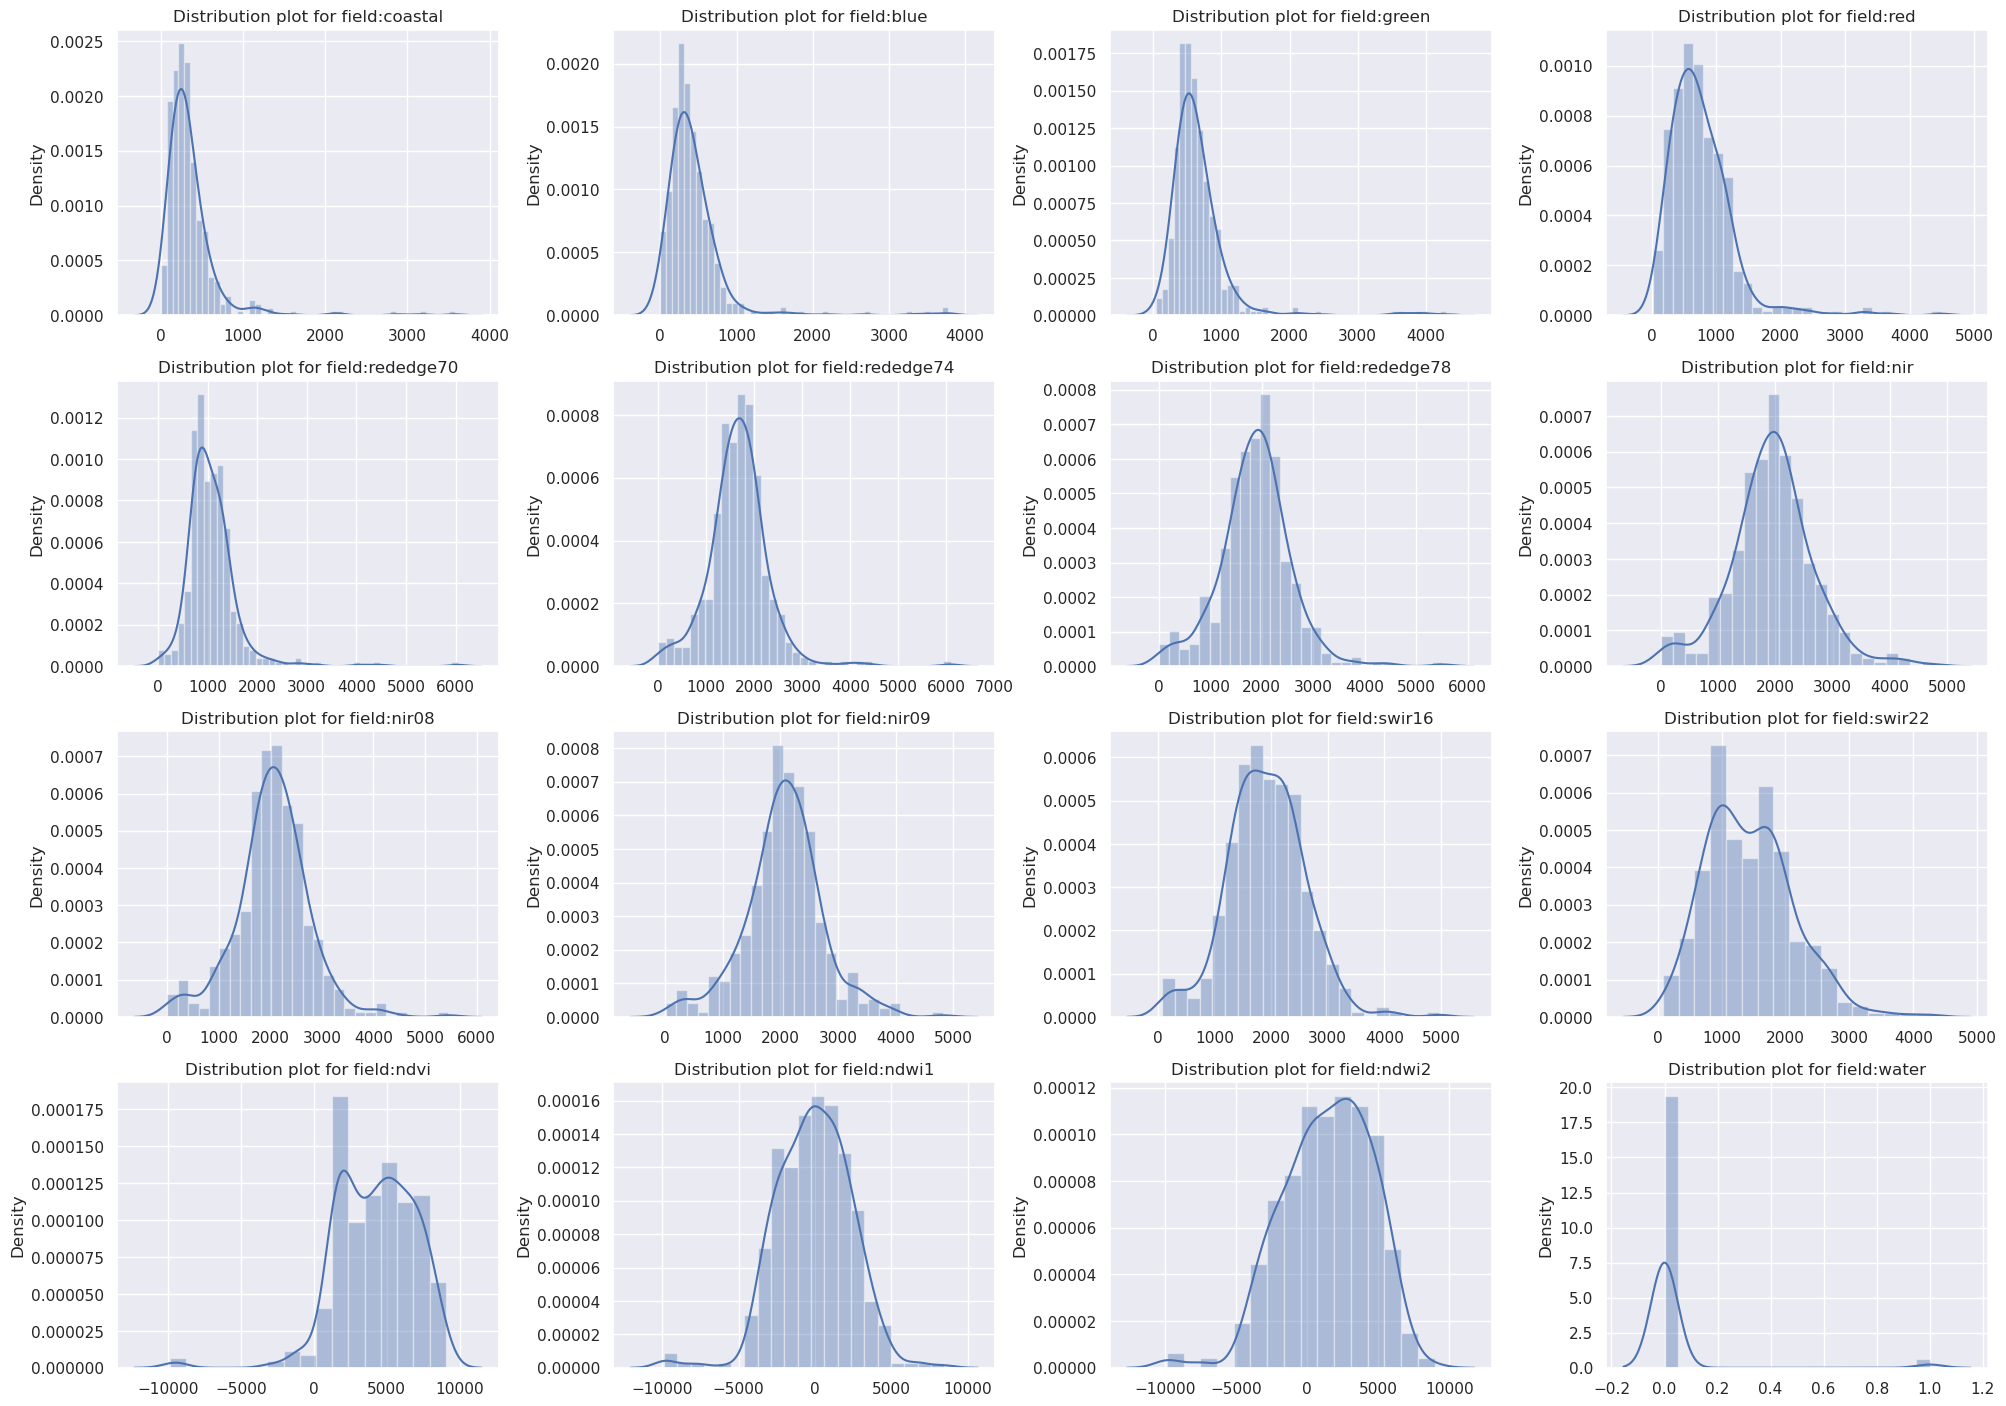

In [14]:
plt.figure(figsize=(20, 14))

for i, c in enumerate(df_pandas.select_dtypes(include='number').columns):
    plt.subplot(4,4,i+1)
    sns.distplot(df_pandas[c])
    plt.title('Distribution plot for field:' + c)
    plt.xlabel('')
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig('output/output_dist_s2_water.png')

We can also target specifically the distribution of specific features when related to the corresponding label.

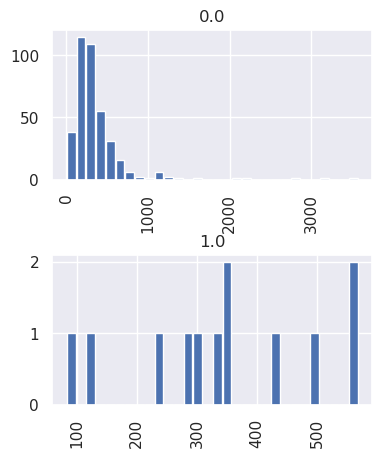

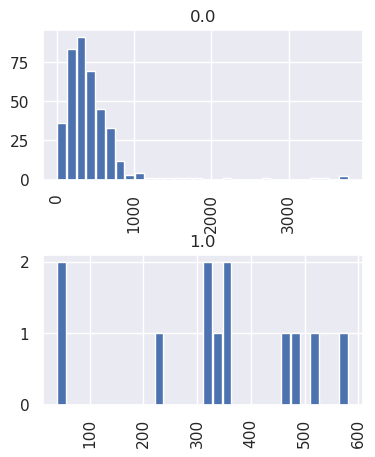

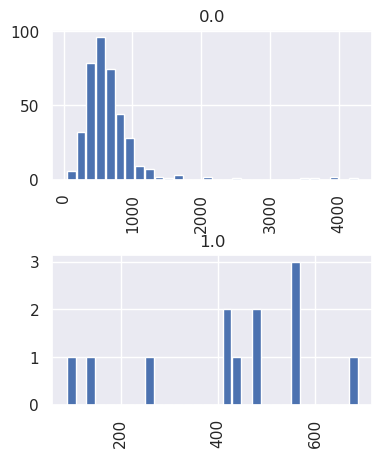

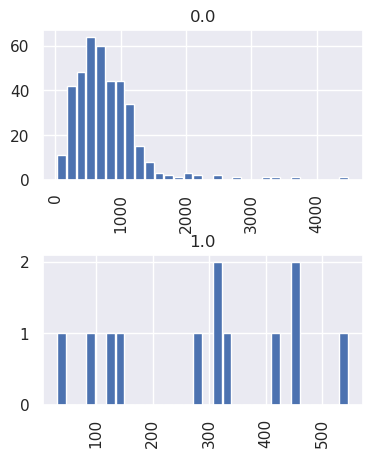

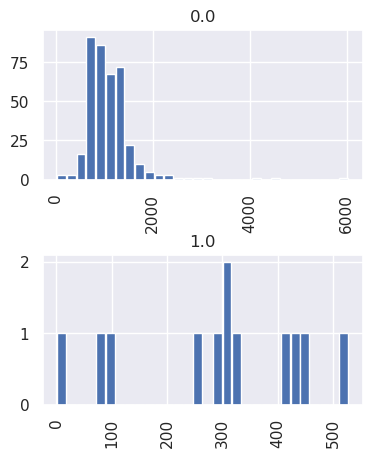

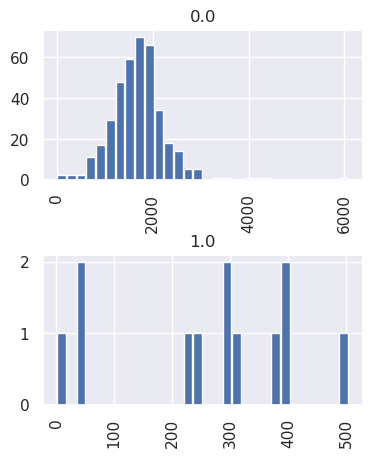

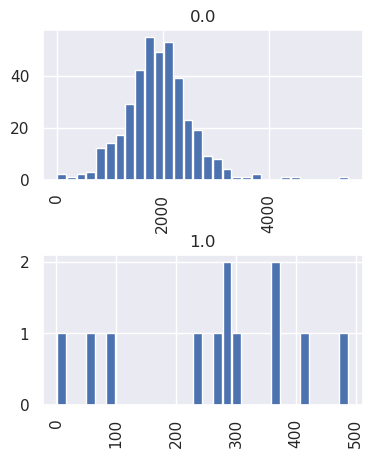

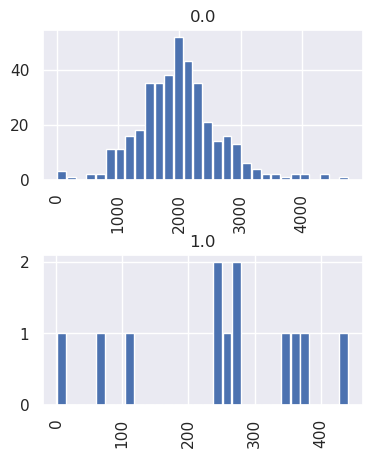

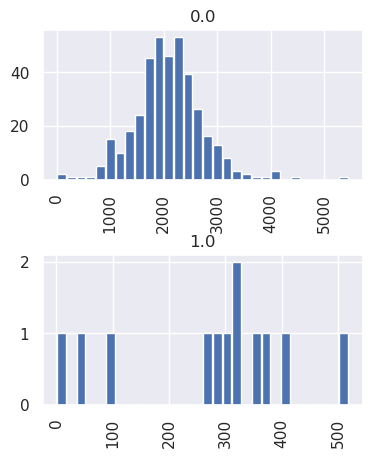

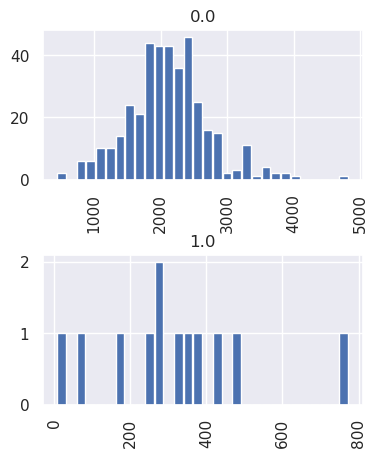

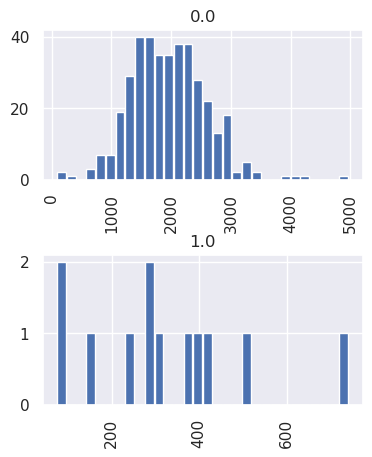

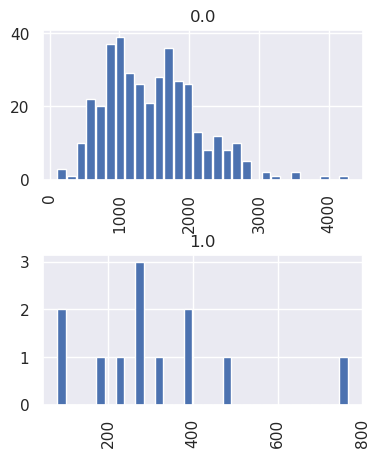

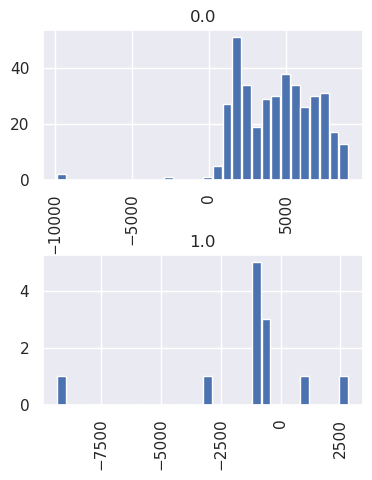

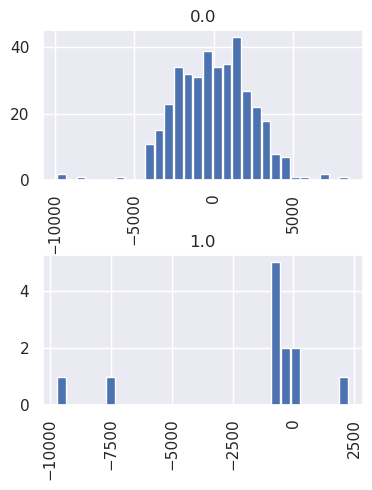

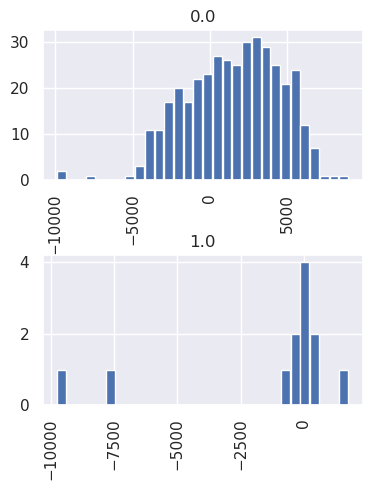

In [15]:
for i, c in enumerate(df_pandas.select_dtypes(include='number').columns):
    if c == LABEL_NAME: continue
    df_pandas.hist(column=c, by=LABEL_NAME, bins=30, grid=True, figsize=(4, 5), layout=(2, 1), zorder=2, rwidth=0.9, sharex=False)

### 5.5 Outlier Detection¶

Finding outliers using the Tukey IQR method: the Tukey IQR rule says that the outliers are values more than 1.5 times the interquartile range from the quartiles — either below Q1 − 1.5 IQR, or above Q3 + 1.5IQR. Thus we can simply calculate outliers per column feature by taking the necessary percentiles.

In [16]:
def find_outliers_tukey(x):
    q1 = np.percentile(x,25)
    q3 = np.percentile(x,75)
    iqr = q3 - q1
    floor = q1 - 1.5*iqr
    ceiling = q3 + 1.5*iqr
    outlier_indices = list(x.index[(x<floor) | (x>ceiling)])
    outlier_values = list(x[outlier_indices])
    
    return outlier_indices,outlier_values

For example, outliers from ndwi2 are listed below:

In [17]:
tukey_indices,tukey_values = find_outliers_tukey(df_pandas['ndwi2'])
np.sort(tukey_values)

array([-9897, -9803, -9764, -7520, -7514])

## 5.6 Feature Engineering, Creating New Features

Future engineering can be used where the available features are not enough for the ML model (eg a small number of features is available, or it is not representative enough). Future engineering can be used in such cases to increase and/or improve our dataset representativeness


In [18]:
def add_interactions(df):
    combos = list(combinations(list(df.columns),2))
    colnames = list(df.columns) + ['_'.join(x) for  x in combos]
    
    poly = PolynomialFeatures(interaction_only=True, include_bias=False)
    df = poly.fit_transform(df)
    df = pd.DataFrame(df)
    df.columns = colnames
    
    noint_indicies = [i for i, x in enumerate(list((df == 0).all())) if x]
    df = df.drop(df.columns[noint_indicies], axis= 1)
    
    return df

In this function we simply produce combinataions of each band that increases out feature space from 10 to 65. For an algorithm like a random forest where decisions are being made, this could provide a substantial improvement. Algorithms like convolutional neural networks might not need these since they can extract patterns directly out of the data.

In [19]:
# df_pandas_expanded = add_interactions(df_pandas)
# df_pandas_expanded.head()

## 5.7 Dimesionality reduction using PCA

PCA is a tecnique that transforms a dataset of many features into pricipal components that summarize the variance that underlies the data. This can also be used to extract the principal components from each feature so they can be used in training.

In [20]:
df_pandas.columns

Index(['coastal', 'blue', 'green', 'red', 'rededge70', 'rededge74',
       'rededge78', 'nir', 'nir08', 'nir09', 'swir16', 'swir22', 'ndvi',
       'ndwi1', 'ndwi2', 'water'],
      dtype='object')

In [21]:
pca = PCA(n_components=len(df_pandas.columns))
X_pca = pd.DataFrame(pca.fit_transform(df_pandas))
X_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,6094.141924,-848.342365,-86.879856,-358.190398,202.954811,219.175982,26.602500,66.037316,-6.587687,-3.114565,8.811612,2.200574,14.787273,-10.374488,-9.480125,-0.054605
1,6921.261164,-1086.488121,-401.827432,-397.754025,228.764294,174.925143,74.975574,-4.942376,31.814619,-113.974098,62.782486,17.440973,-5.358509,-43.148817,33.659884,-0.020010
2,2880.280880,175.874922,-117.237864,-11.265778,229.972790,-37.888697,-322.719639,-253.274674,168.881476,8.952816,49.886138,-62.495358,-9.929885,98.142057,-28.480409,-0.066274
3,-2458.113748,-576.579510,392.333762,230.876269,-72.286100,-476.556521,-39.429958,-100.905458,59.902722,-64.845285,-21.627070,-94.426539,-2.276199,14.491088,10.563739,0.028692
4,5749.570987,-59.789949,-766.873991,-414.777095,-203.715871,220.261894,-46.195835,257.646827,-55.103646,12.138577,-33.661428,-58.735550,32.636560,6.759036,34.109662,-0.000343
